In [10]:
import sys
sys.path.append('/Users/aakash/anaconda3/envs/gis/lib/python3.6/site-packages')
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
import os
import datetime
import geopandas as gp

ee.Initialize()


OSError: dlopen(/Users/aakash/anaconda3/lib/libspatialindex_c.dylib, 6): image not found

In [4]:
# Set the area
pt = ee.Geometry.Point([-120.08794784545898, 36.58796570529717])
area = pt.buffer(1000)

In [5]:
# Get the RS products
collection = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(pt).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')).filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')).select('VV')
before = collection.filterDate('2016-01-20', '2017-02-01').mosaic()
after = collection.filterDate('2017-02-08', '2017-02-14').mosaic()

In [6]:
# Some params
SMOOTHING_RADIUS = 20;
DIFF_UPPER_THRESHOLD = -4; 


In [7]:
def make_np_array(data, lats, lons):
    # get data from df as arrays
    lons = np.array(lons)
    lats = np.array(lats)
    data = np.array(data) # Set var here 
                                              
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)

    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)    
    nrows = len(uniqueLats)

    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0] 
    xs = uniqueLons[1] - uniqueLons[0]

    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32)

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
    
    return arr

def df_from_ee_object(imcol):
    df = pd.DataFrame(imcol, columns = imcol[0])
    df = df[1:]
    return(df)


def array_from_latlon(latlon_obj):
    res = latlon_obj.reduceRegion(reducer=ee.Reducer.toList(),geometry=area,maxPixels=1e8,scale=20)
    data = np.array((ee.Array(res.get("VV")).getInfo()))
    lats = np.array((ee.Array(res.get("latitude")).getInfo()))
    lons = np.array((ee.Array(res.get("longitude")).getInfo()))
    out = make_np_array(data, lats, lons)
    return out

def format_df_from_csv(df): # kills off whitespace and other bs 
    df.columns = [t.strip() for t in list(df)]
    df.columns = df.columns.str.replace('\s+','')  # remove whitespace from headers
    df.columns = df.columns.str.lower()

    return df

In [8]:
# get the lat lon and add the sar amplitude
latlon = ee.Image.pixelLonLat().addBands(after)

# Make an array
after_arr = array_from_latlon(latlon)

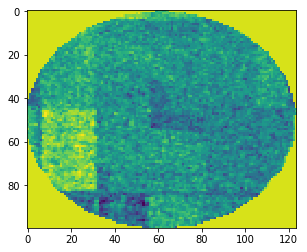

In [9]:
plt.imshow(after_arr)
plt.show()

In [ ]:
# Load the tables and clean them thoroughly

In [7]:
xls = pd.ExcelFile('flood_recharge.xlsx')

sheets = ['30-Mid', '30-W', '30-S', '30e', '18s', '18w', "1", "58", "54", "52"]
dfs = []

for sheet in sheets:
    dfs.append(pd.read_excel(xls, sheet, skiprows = 3))

cdfs = []
for d in dfs:
    cdfs.append(d[pd.notnull(d["Water Destination"])])

fdfs = []
for i in cdfs:
    fdfs.append(format_df_from_csv(i))

cc = pd.concat(fdfs)
cleaned = cc.reset_index(drop = True)

final_data = cleaned.sort_values(by="date", axis=0).reset_index(drop = True)
final = final_data[pd.notnull(final_data["afapplied/day"])]
f = final[final["afapplied/day"] !=0.0]
fin = f.sort_values(by = "date").reset_index(drop = True)

fin.waterdestination = fin.waterdestination.str.split()

wds = []
for i in fin.waterdestination:
    result = [x for x in i if x.isdigit()]
    wds.append(result)
    
fin.waterdestination = wds

#fin['timestamp'] = pd.to_datetime(fin['date'])

fin['date'] =  pd.to_datetime(fin.date)#['date'], format='%d%b%Y%f')


In [8]:
uniques = np.unique(fin.waterdestination).tolist()
flattened = [val for sublist in uniques for val in sublist]
fields = set(flattened)

In [9]:
# Read the shapefile

In [10]:
shpdir = os.path.join(os.getcwd(),[x for x in os.listdir(os.getcwd()) if os.path.isdir(x)][0])

In [11]:
shp = [os.path.join(shpdir,x) for x in os.listdir(shpdir) if x.endswith(".shp")][0]

In [12]:
gdf = gp.read_file(shp)

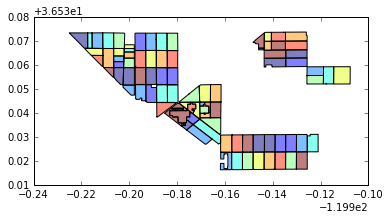

In [13]:
gdf.plot()
plt.show()

In [ ]:
# scratch

In [14]:
alldates = np.unique(fin.date)
for d in alldates[0:1]:
    startdate = pd.to_datetime(d)
    enddate = startdate + pd.DateOffset(days=7)
    after = collection.filterDate(startdate, enddate).mosaic()
    before = collection.filterDate(startdate + pd.DateOffset(years = -1), enddate + pd.DateOffset(years = -1)).mosaic()

In [15]:
bf = ee.Image.pixelLonLat().addBands(before)
af = ee.Image.pixelLonLat().addBands(after)

In [23]:
im1 = array_from_latlon(bf)
im2 = array_from_latlon(af)
diff = im1 - im2
res = np.where(diff, diff<-5, 1)

In [24]:
print(res)

[[1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


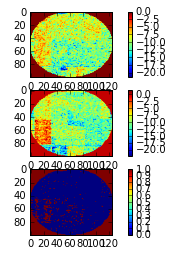

In [26]:
plt.subplot(3,1,1)
plt.imshow(im1)
plt.colorbar()

plt.subplot(3,1,2)
plt.imshow(im2)
plt.colorbar()

plt.subplot(3,1,3)
plt.imshow(res)
plt.colorbar()

plt.show()